In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import io
data = pd.read_csv(io.BytesIO(data['icml_face_data  (5).csv']))
data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/FaceRecognition/icml_face_data/icml_face_data.csv') 
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


Train.info()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
Train = pd.read_csv('/content/drive/MyDrive/FaceRecognition/train/train.csv')
Train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
Test = pd.read_csv('/content/drive/MyDrive/FaceRecognition/test/test.csv')
Test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [8]:
data[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

In [9]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


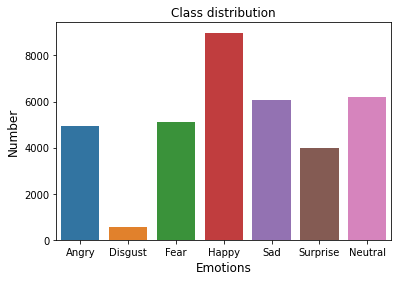

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

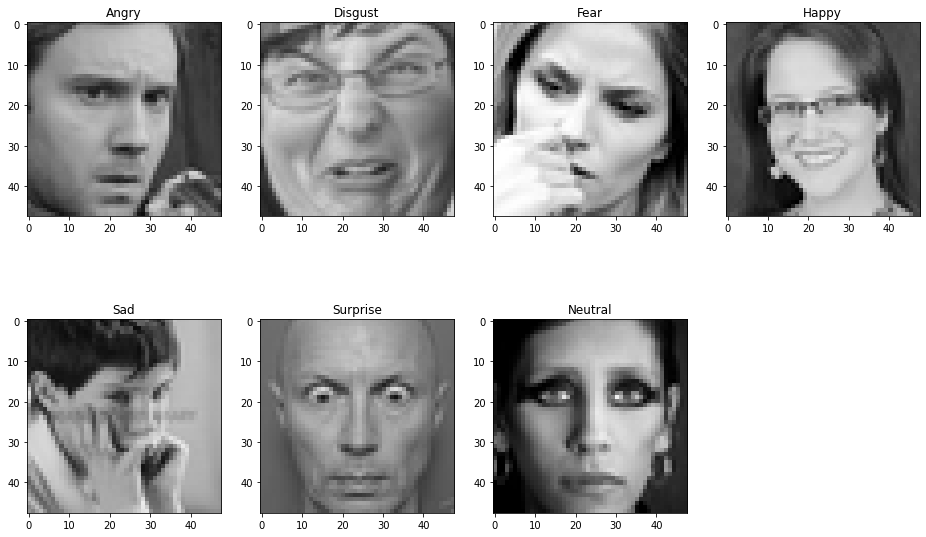

In [11]:
def row2image(row):
    pixels, emotion = row[' pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [12]:
data[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

In [13]:
x_train,x_test,y_train,y_test=[],[],[],[]
for row in Train.values:
    value=row[0]
    pixels=row[1].split(' ')
    x_train.append(np.array(pixels,'float32'))
    y_train.append(value)

for row in Test.values:
    pixels=row[0].split(' ')
    x_test.append(np.array(pixels,'float32'))
y_test=data[(data[' Usage']=='PublicTest')|(data[' Usage']=='PrivateTest')]['emotion'].values

In [14]:
x_train=np.array(x_train,'float32')
y_train=np.array(y_train,'float32')
x_test=np.array(x_test,'float32')
y_test=np.array(y_test,'float32')

In [15]:
x_test.shape,x_train.shape,y_train.shape,y_test.shape

((7178, 2304), (28709, 2304), (28709,), (7178,))

In [16]:
x_train_f=x_train.reshape(x_train.shape[0],48,48,1)
x_test_f=x_test.reshape(x_test.shape[0],48,48,1)

In [17]:
#NORMALISATIOn
x_train_f/=255
x_test_f/=255

print(x_train_f)

[[[[0.27450982]
   [0.3137255 ]
   [0.32156864]
   ...
   [0.20392157]
   [0.16862746]
   [0.16078432]]

  [[0.25490198]
   [0.23921569]
   [0.22745098]
   ...
   [0.21960784]
   [0.20392157]
   [0.17254902]]

  [[0.19607843]
   [0.16862746]
   [0.21176471]
   ...
   [0.19215687]
   [0.21960784]
   [0.18431373]]

  ...

  [[0.35686275]
   [0.25490198]
   [0.16470589]
   ...
   [0.28235295]
   [0.21960784]
   [0.16862746]]

  [[0.3019608 ]
   [0.32156864]
   [0.30980393]
   ...
   [0.4117647 ]
   [0.27450982]
   [0.18039216]]

  [[0.3019608 ]
   [0.28235295]
   [0.32941177]
   ...
   [0.41568628]
   [0.42745098]
   [0.32156864]]]


 [[[0.5921569 ]
   [0.5882353 ]
   [0.5764706 ]
   ...
   [0.5058824 ]
   [0.54901963]
   [0.47058824]]

  [[0.5921569 ]
   [0.58431375]
   [0.58431375]
   ...
   [0.47843137]
   [0.5529412 ]
   [0.5372549 ]]

  [[0.5921569 ]
   [0.5921569 ]
   [0.6117647 ]
   ...
   [0.42745098]
   [0.48235294]
   [0.57254905]]

  ...

  [[0.7372549 ]
   [0.7372549 ]
   [0.4

In [18]:
y_test=to_categorical(y_test)
y_train=to_categorical(y_train)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
import os


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_data_dir='/content/drive/MyDrive/FaceRecognition/train/train.csv'
validation_data_dir='/content/drive/MyDrive/FaceRecognition/test/test.csv'

In [21]:

train_generator = train_datagen.flow_from_directory(
                        '/content/drive/MyDrive/FaceRecognition/train/',
                        color_mode='grayscale',
                        target_size=(48,48),
                        batch_size=32,
                        class_mode='categorical',
                        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                                '/content/drive/MyDrive/FaceRecognition/test/',
                                color_mode='grayscale',
                                target_size=(48,48),
                                batch_size=32,
                                class_mode='categorical',
                                shuffle=True)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [22]:
train_aug = ImageDataGenerator(rotation_range=10,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               rescale=1 / 255.0,
                               fill_mode="nearest")

In [23]:
#Initialize Parameters
num_classes = 7
epochs = 55
batch_size = 100
num_features = 32
width, height = 48,48

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

In [24]:
model=Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', strides = (1,1), padding = 'same', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu',strides = (1,1), padding = 'same', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), activation='relu',strides = (1,1), padding = 'same', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))



model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))




print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       2

model = Sequential()
model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=7, activation="softmax"))


print(model.summary())

In [25]:
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model.compile(loss="categorical_crossentropy",     # Fonction d'erreur
            optimizer=Adam(learning_rate=0.001), # Optimisation de l'apprentissage
              metrics=["accuracy"])


es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,min_delta=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


checkpoint = ModelCheckpoint('/content/drive/MyDrive/FaceRecognition/model_weights.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)



history3=model.fit(x_train_f,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test_f,y_test),callbacks=[es,reduce_lr,checkpoint])
history3

Epoch 1/55
288/288 [==============================] - 21s 49ms/step - loss: 1.8929 - accuracy: 0.2248 - val_loss: 1.7841 - val_accuracy: 0.2608

Epoch 00001: val_loss improved from inf to 1.78411, saving model to /content/drive/MyDrive/FaceRecognition/model_weights.h5
Epoch 2/55
288/288 [==============================] - 14s 48ms/step - loss: 1.7189 - accuracy: 0.3062 - val_loss: 1.5909 - val_accuracy: 0.3890

Epoch 00002: val_loss improved from 1.78411 to 1.59090, saving model to /content/drive/MyDrive/FaceRecognition/model_weights.h5
Epoch 3/55
288/288 [==============================] - 14s 47ms/step - loss: 1.5837 - accuracy: 0.3819 - val_loss: 1.4784 - val_accuracy: 0.4248

Epoch 00003: val_loss improved from 1.59090 to 1.47838, saving model to /content/drive/MyDrive/FaceRecognition/model_weights.h5
Epoch 4/55
288/288 [==============================] - 14s 47ms/step - loss: 1.5044 - accuracy: 0.4165 - val_loss: 1.3689 - val_accuracy: 0.4746

Epoch 00004: val_loss improved from 1.47

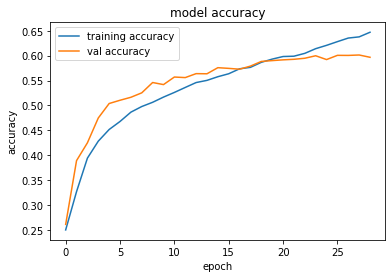

In [26]:
  import keras
from matplotlib import pyplot as plt

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'val accuracy'], loc='upper left')
plt.show()


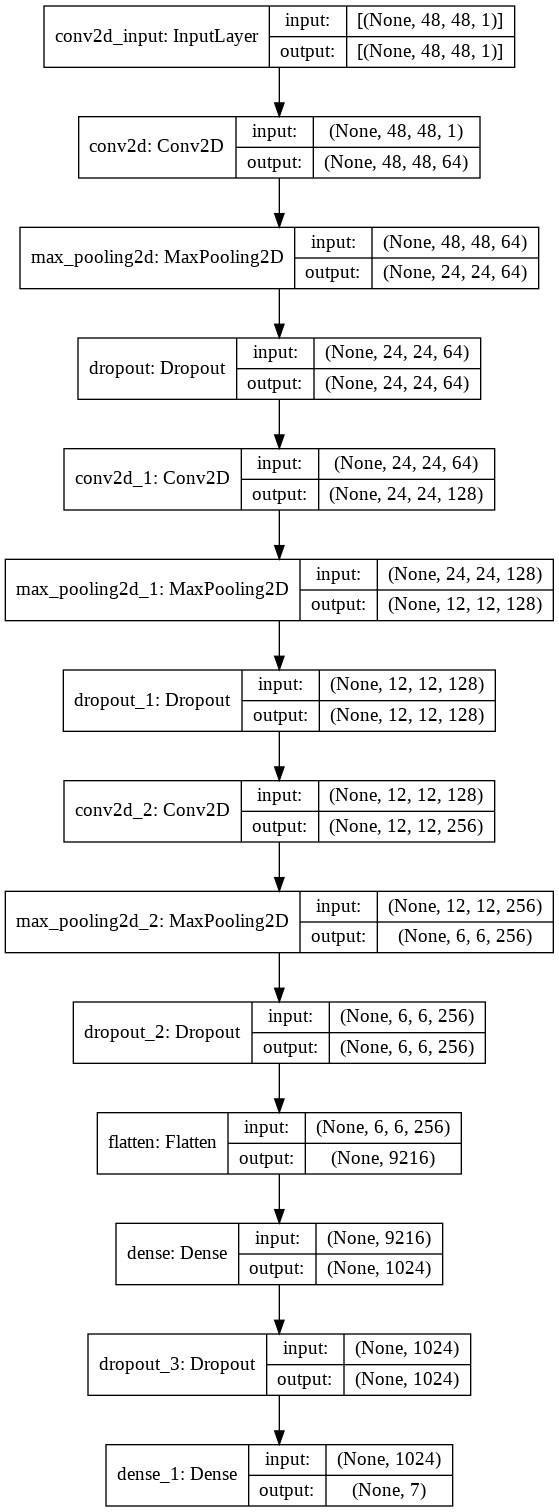

In [27]:
import tensorflow as tf

tf.keras.utils.plot_model(model,show_shapes=True)

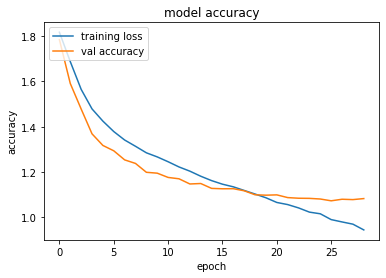

In [28]:
import keras
from matplotlib import pyplot as plt

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training loss', 'val accuracy'], loc='upper left')
plt.show()

In [29]:
score = model.evaluate(x_test_f, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

225/225 [==============================] - 2s 7ms/step - loss: 1.0834 - accuracy: 0.5967
Test loss: 1.0834145545959473
Test accuracy: 0.5966843366622925


In [30]:
y_pred=model.predict(x_test_f)
y_pred_class=model.predict_classes(x_test_f)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 Here is a  Sad  and the model has predicted a  Happy ... 

Error of prediction...


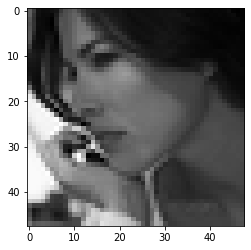

In [31]:
from random import randint

indice = randint(0, y_test.shape[0]-1)

image = x_test_f[indice]
label = np.argmax(y_test[indice])

image = np.expand_dims(image, 0) # permet d'avoir un batch_size = 1
#                                # car l'IA prend des données de dimension 4 (batch_size, hauteur, largeur, channels)
#                                # channels sert pour les images en couleurs par exemple (RGB)

prediction = model.predict(image)   # On effectue la prédiction

prediction = np.squeeze(prediction) # On enlève les dimensions inutiles (ici batch_size : en effet on passe d'une matrice (1, 10) à un vecteur (10,))

prediction = np.argmax(prediction)  # Changer [0, 0, 1, 0, 0, 0] en 2 par exemple (mais ici on est sur des vecteurs de dimension 10)

import matplotlib.pyplot as plt

print("\n Here is a ",emotion_map[label], " and the model has predicted a ", emotion_map[prediction], "... \n")

plt.axis('on')
plt.imshow(np.squeeze(image), cmap=plt.get_cmap("gray"));


if label == prediction:
  print('The model has correctly predicted it !' )
else:
  print('Error of prediction...')

    




In [32]:
#emotion_map[y_test[indice]]
y_test[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
[y_pred[0]]

[array([0.32336134, 0.11573565, 0.05059778, 0.3473642 , 0.103553  ,
        0.00790669, 0.0514813 ], dtype=float32)]

In [34]:
y_proba = model.predict(image)
randImage = y_proba.round(3)
randImage = randImage.reshape(7)
randImage = randImage.tolist()
randImage

[0.12600000202655792,
 0.061000000685453415,
 0.12099999934434891,
 0.4269999861717224,
 0.2160000056028366,
 0.014000000432133675,
 0.03500000014901161]

In [35]:
y_pred = np.argmax(model.predict(image), axis=-1)
emotion_map[y_pred[0]]

'Happy'

In [36]:
target_names = ['Angry','Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral']

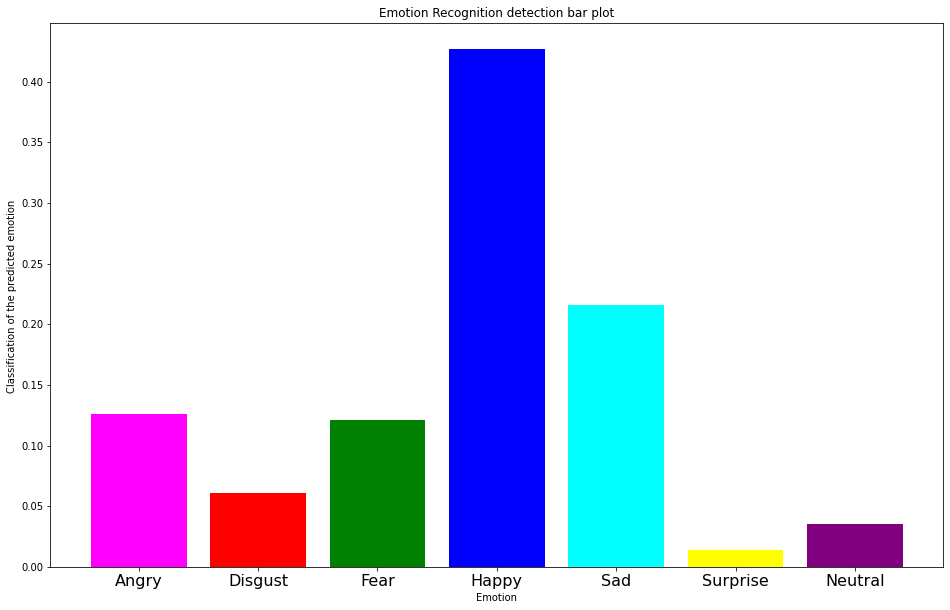

In [37]:
f = plt.subplots(figsize=(16,10))

plt.bar(target_names,randImage,color=['magenta', 'red', 'green', 'blue', 'cyan','yellow', 'purple'])
plt.title('Emotion Recognition detection bar plot')
plt.ylabel('Classification of the predicted emotion ')
plt.xlabel('Emotion')
plt.xticks(fontsize = 16)
plt.show()

In [38]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [39]:
data['Emotion2'] = data['emotion']

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}



data['Emotion2']=data['emotion'].map(emotion_map)
data


,emotion,Usage,pixels,Emotion2
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,Angry
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral
...,...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,Neutral
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...,Happy
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,Angry
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,Happy


In [40]:
y_pred=model.predict(x_test_f)
y_pred_class=model.predict_classes(x_test_f)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [41]:
from sklearn.metrics import classification_report as cr,confusion_matrix as cm
import seaborn as sn
import numpy as np

target_names = ['Angry','Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral']

print(cr(np.argmax(y_test,axis=1),y_pred_class,target_names=target_names))

confusionmatrix = cm(np.argmax(y_test,axis=1),y_pred_class)
print(confusionmatrix)


              precision    recall  f1-score   support

       Angry       0.58      0.40      0.47       958
     Disgust       0.80      0.51      0.63       111
        Fear       0.58      0.25      0.35      1024
       Happy       0.73      0.85      0.79      1774
         Sad       0.43      0.55      0.48      1247
    Surprise       0.76      0.77      0.77       831
     Neutral       0.49      0.61      0.55      1233

    accuracy                           0.60      7178
   macro avg       0.63      0.56      0.58      7178
weighted avg       0.60      0.60      0.58      7178

[[ 380    6   41  115  238   27  151]
 [  14   57    2    7   22    2    7]
 [  93    4  259   92  282  110  184]
 [  34    0   21 1505   92   27   95]
 [  65    0   60  130  688   15  289]
 [  21    1   37   59   29  639   45]
 [  44    3   29  143  243   16  755]]


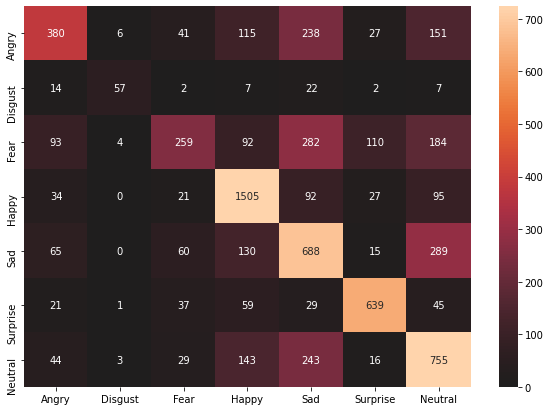

In [42]:
df_cm = pd.DataFrame(confusionmatrix, index = target_names,
                  columns = target_names)

plt.figure(figsize = (10,7))
ax=sn.heatmap(df_cm, annot=True,fmt="d",vmin=0, vmax=724,center=0)



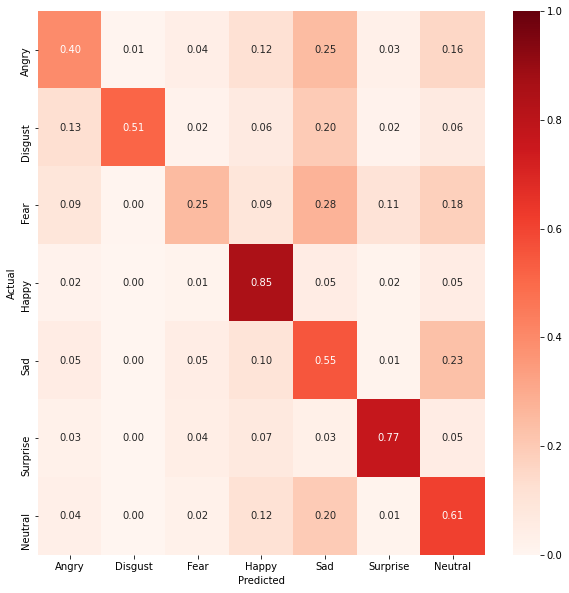

In [43]:
confusionmatrix = cm(np.argmax(y_test,axis=1),y_pred_class)
cmn = confusionmatrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap ='Reds', vmax=1,vmin=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
data.Emotion2.value_counts()

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: Emotion2, dtype: int64

In [45]:
data.head()

,emotion,Usage,pixels,Emotion2
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,Angry
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral


from keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/FaceRecognition/TrumpBW.jpg',target_size =(48,48,1))
test_image =image.img_to_array(test_image)
result = model.predict(test_image)


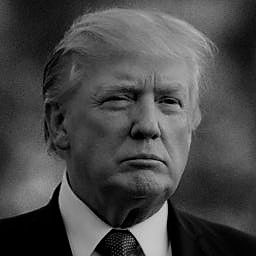

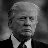

(1, 48, 48, 1)

In [46]:
import cv2
from google.colab.patches import cv2_imshow

# Input image
input = cv2.imread('/content/drive/MyDrive/FaceRecognition/TrumpBW.jpg',0)

# Get input size
height, width = input.shape[:2]

# Desired "pixelated" size
w, h = (48, 48)

# Resize input to "pixelated" size
temp = cv2.resize(input, (w, h), interpolation=cv2.INTER_LINEAR)

# Initialize output image
output = cv2.resize(temp, (w, h), interpolation=cv2.INTER_NEAREST)

cv2_imshow(input)
print('')
cv2_imshow(output)
print ('')
output.shape

img = output.reshape(48, 48, 1)
img = np.expand_dims(img, axis=0)
img = img / 255.0
img.shape


In [47]:
y_pred = np.argmax(model.predict(img), axis=-1)
x2 = emotion_map[y_pred[0]]
x2

'Angry'

In [48]:
y_proba = model.predict(img)
xa = y_proba.round(3)
xa = xa.reshape(7)
xa1 = xa.tolist()
xa1

[0.4440000057220459,
 0.0010000000474974513,
 0.10999999940395355,
 0.19099999964237213,
 0.19900000095367432,
 0.003000000026077032,
 0.052000001072883606]

In [49]:
index2 = np.arange(7)
index2
print(index2.shape)

(7,)


In [50]:
index = np.arange(len(emotion_counts))
index.shape

(7,)

In [51]:
target_names = ['Angry','Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral']

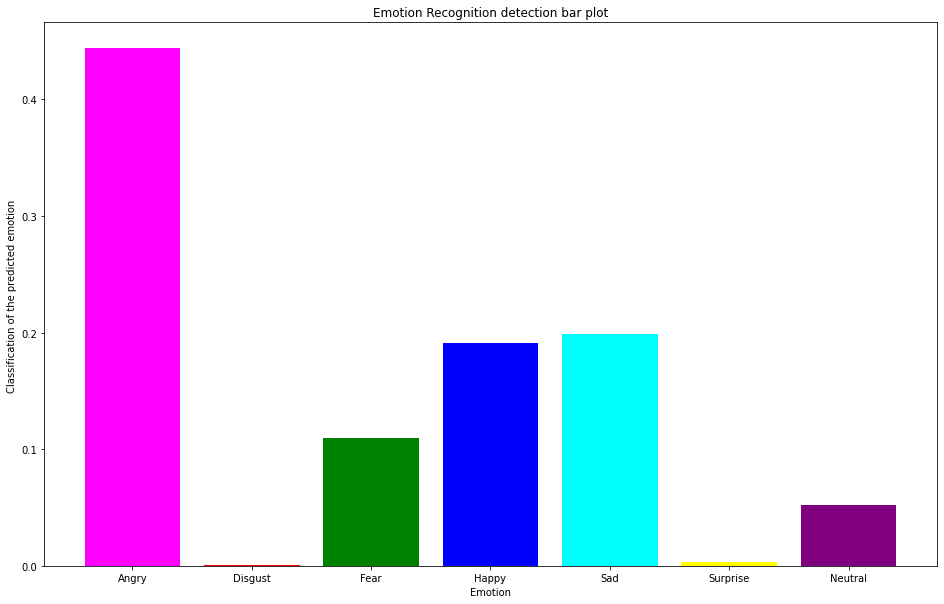

In [52]:
f = plt.subplots(figsize=(16,10))

plt.bar(target_names,xa1,color=['magenta', 'red', 'green', 'blue', 'cyan','yellow', 'purple'])
plt.title('Emotion Recognition detection bar plot')
plt.ylabel('Classification of the predicted emotion ')
plt.xlabel('Emotion')
plt.show()

In [53]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Input image
input = cv2.imread('/content/drive/MyDrive/FaceRecognition/TrumpBW.jpg',0)

# Get input size
height, width = input.shape[:2]

# Desired "pixelated" size
w, h = (48, 48)

# Resize input to "pixelated" size
temp = cv2.resize(input, (w, h), interpolation=cv2.INTER_LINEAR)

# Initialize output image
output = cv2.resize(temp, (w, h), interpolation=cv2.INTER_NEAREST)

cv2_imshow(input)
print('')
cv2_imshow(output)
print ('')
output.shape

img = output.reshape(48, 48, 1)
img = np.expand_dims(img, axis=0)
img = img / 255.0
img.shape

In [54]:
model_json = model.to_json()
with open("/content/drive/MyDrive/FaceRecognition/model.json","w") as json_file:
  json_file.write(model_json)

In [55]:



#face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + '/content/drive/MyDrive/FaceRecognition/haarcascade_frontalface_default.xml')

#classifier = load_model('/content/drive/MyDrive/FaceRecognition/EmotionDetectionModel.h5')

In [56]:

#class_labels=['Happy','Neutral','Sad','Fear', 'Angry', 'Surprise', 'Disgust']
#cap=cv2.VideoCapture(0)


In [57]:
x_train_f.shape


(28709, 48, 48, 1)

In [58]:
y_pred = np.argmax(model.predict(img), axis=-1)
x2 = emotion_map[y_pred[0]]
x2

'Angry'

In [59]:
num_classes = 7
epochs = 40
batch_size = 64
num_features = 32
width, height = 48,48

from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

model = Sequential()
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2),padding="same"))
model.add(Dropout(0.25))


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(7, activation='softmax'))
model.summary()




# model.fit(X_train, Y_train, batch_size=64, epochs=40, steps_per_epoch=(len(X_train)/128))

model.compile(     # Fonction d'erreur
            optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])






model.fit(x_train_f,y_train,epochs=epochs,batch_size=batch_size,callbacks=[es,reduce_lr,checkpoint])

In [60]:
score = model.evaluate(x_test_f, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

225/225 [==============================] - 2s 8ms/step - loss: 1.0834 - accuracy: 0.5967
Test loss: 1.0834145545959473
Test accuracy: 0.5966843366622925
